# Import packages

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Investigate data

In [3]:
coffee = pd.read_csv("coffee_data_clean_full.csv")

In [5]:
data = coffee

In [2]:
arabica = pd.read_csv("arabica_data_cleaned.csv")
robusta = pd.read_csv("robusta_data_cleaned.csv")

FileNotFoundError: File b'arabica_data_cleaned.csv' does not exist

In [39]:
frames = [arabica, robusta]

In [40]:
data = pd.concat(frames)

Remove first column

In [41]:
data = data.iloc[:, 1:]

In [6]:
data.columns

Index(['Species', 'Owner', 'Country.of.Origin', 'Farm.Name', 'Lot.Number',
       'Mill', 'ICO.Number', 'Company', 'Altitude', 'Region', 'Producer',
       'Number.of.Bags', 'Bag.Weight', 'In.Country.Partner', 'Harvest.Year',
       'Grading.Date', 'Owner.1', 'Variety', 'Processing.Method', 'Aroma',
       'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity',
       'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points',
       'Moisture', 'Category.One.Defects', 'Quakers', 'Color',
       'Category.Two.Defects', 'Expiration', 'Certification.Body',
       'Certification.Address', 'Certification.Contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')

# Clean data

In [7]:
df = pd.DataFrame(data)

Convert Expiration to datetime

In [8]:
df['Expiration']=pd.to_datetime(df.Expiration)

In [9]:
df['Expiration'].head()

0   2016-04-03
1   2016-04-03
2   2011-05-31
3   2016-03-25
4   2016-04-03
Name: Expiration, dtype: datetime64[ns]

Convert Grading.Year to datetime

In [10]:
df['Grading.Date']=pd.to_datetime(df.Expiration)

In [11]:
df['Grading.Date'].head()

0   2016-04-03
1   2016-04-03
2   2011-05-31
3   2016-03-25
4   2016-04-03
Name: Grading.Date, dtype: datetime64[ns]

Convert Harvest.Year into datetime

In [12]:
df.iloc[:,14] = df.iloc[:,14].str[-4:]

In [13]:
df.iloc[:,14].head()

0    0:00
1    0:00
2    0:00
3    0:00
4    0:00
Name: Harvest.Year, dtype: object

In [14]:
def replace_alpha (x):
    if any(c.isalpha() for c in str(x)):
        x = 2014
    return x

df.iloc[:,14] = df.apply(lambda x: replace_alpha(x['Harvest.Year']), axis=1)

In [15]:
df.iloc[:,14].head()

0    0:00
1    0:00
2    0:00
3    0:00
4    0:00
Name: Harvest.Year, dtype: object

In [16]:
df['Harvest.Year']=pd.to_datetime(df['Harvest.Year'])

Convert all Bluish-Green colour to Blue-Green.

In [17]:
df.Color = df.Color.replace('Bluish-Green', 'Blue-Green')

In [18]:
df.Color.head(10)

0         Green
1         Green
2           NaN
3         Green
4         Green
5    Blue-Green
6    Blue-Green
7           NaN
8           NaN
9         Green
Name: Color, dtype: object

Convert lbs to kg and strip away units

In [19]:
def weight_conversion(x):
    if 'lbs' in str(x):
        x = int(re.sub("[^0-9]", "", x))
        return x * 0.453592
    else:
        return x

df.iloc[:,12] = df.apply(lambda row: weight_conversion(row['Bag.Weight']), axis=1)

In [20]:
def remove_characters(x):
    non_decimal = re.compile(r'[^\d.]+')
    x = non_decimal.sub('', str(x))
    return x

df.iloc[:,12] = df.apply(lambda x: remove_characters(x['Bag.Weight']), axis=1)

In [21]:
df.iloc[:,12] = df.iloc[:,12]

In [22]:
df.iloc[:,12].head()

0    60
1    60
2     1
3    60
4    60
Name: Bag.Weight, dtype: object

In [23]:
df.to_csv("coffee_data_clean.csv", encoding='utf-8', index=False)

# Prepare data for ML

In [98]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Building a model to predict points

In [65]:
total_points=df['Total.Cup.Points']

Select columns that are relevant for predicting coffee quality
 - Removed owner

In [91]:
df_ml = df[['Species', 'Country.of.Origin', 'Region', 'Harvest.Year',
       'Variety', 'Processing.Method', 'Aroma',
       'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity',
       'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points',
       'Moisture', 'Category.One.Defects', 'Quakers', 'Color',
       'Category.Two.Defects', 'altitude_low_meters', 'altitude_high_meters']]

In [92]:
for column in df_ml:
    print (column, "Unique items: ", len(np.unique(df[column].astype(str))))

Species Unique items:  2
Country.of.Origin Unique items:  37
Region Unique items:  357
Harvest.Year Unique items:  11
Variety Unique items:  30
Processing.Method Unique items:  6
Aroma Unique items:  33
Flavor Unique items:  35
Aftertaste Unique items:  35
Acidity Unique items:  31
Body Unique items:  33
Balance Unique items:  33
Uniformity Unique items:  10
Clean.Cup Unique items:  11
Sweetness Unique items:  17
Cupper.Points Unique items:  42
Total.Cup.Points Unique items:  180
Moisture Unique items:  23
Category.One.Defects Unique items:  18
Quakers Unique items:  12
Color Unique items:  4
Category.Two.Defects Unique items:  38
altitude_low_meters Unique items:  199
altitude_high_meters Unique items:  199


Categorical data:
- Color
- Country.of.Origin
- Processing.Method
- Variety
- Harvest.Year

In [213]:
categorical = df_ml[['Species', 'Country.of.Origin', 'Color', 'Processing.Method', 'Variety', 'Harvest.Year']]

In [214]:
le = LabelEncoder()
column_labels = ['Species.Label', 'Country.of.Origin.Label', 'Color.Label', 'Processing.Method.Label', 'Variety.Label', 'Harvest.Year.Label']

In [215]:
for index, column in enumerate(categorical):
    labels = le.fit_transform(categorical[column].astype(str))
    categorical[column_labels[index]] = labels

C:\Users\bking\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [216]:
cat_labels = categorical[column_labels]

One hot encoding

In [217]:
ohe = OneHotEncoder()
features_all = pd.DataFrame()
for index, column in enumerate(cat_labels):
    feature_arr = ohe.fit_transform(
        cat_labels[[column]]).toarray()
    labels = le.fit_transform(categorical[column].astype(str))
    feature_labels = list(le.classes_)
    feature_labels = [column + s for s in feature_labels]
    features = pd.DataFrame(feature_arr, columns=feature_labels)
    features_all = pd.concat([features_all, features], axis=1)

In [218]:
features_all.head()

,Species.Label0,Species.Label1,Country.of.Origin.Label0,Country.of.Origin.Label1,Country.of.Origin.Label10,Country.of.Origin.Label11,Country.of.Origin.Label12,Country.of.Origin.Label13,Country.of.Origin.Label14,Country.of.Origin.Label15,...,Harvest.Year.Label1,Harvest.Year.Label10,Harvest.Year.Label2,Harvest.Year.Label3,Harvest.Year.Label4,Harvest.Year.Label5,Harvest.Year.Label6,Harvest.Year.Label7,Harvest.Year.Label8,Harvest.Year.Label9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


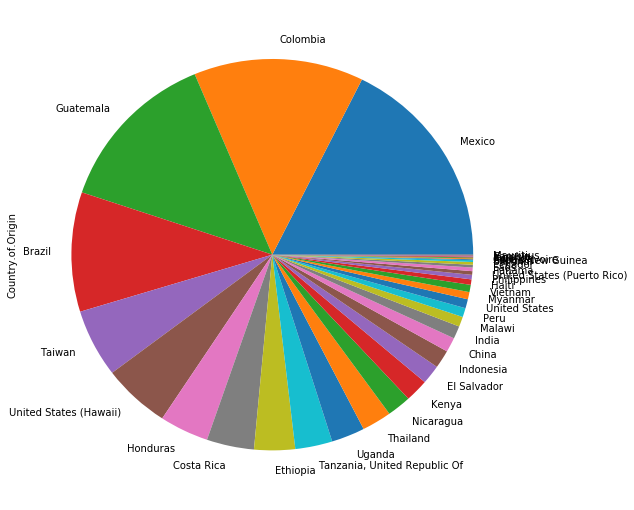

In [219]:
plt.figure(figsize=(3*3,3*3))
df_ml["Country.of.Origin"].value_counts().plot.pie()
plt.show()

In [220]:
categorical.head()

,Species,Country.of.Origin,Color,Processing.Method,Variety,Harvest.Year,Species.Label,Country.of.Origin.Label,Color.Label,Processing.Method.Label,Variety.Label,Harvest.Year.Label
0,Arabica,Ethiopia,Green,Washed / Wet,NaN,2014-01-01 00:00:00.000000000,0,8,1,4,29,6
1,Arabica,Ethiopia,Green,Washed / Wet,Other,2014-01-01 00:00:00.000000000,0,8,1,4,15,6
2,Arabica,Guatemala,NaN,NaN,Bourbon,1970-01-01 00:00:00.000002014,0,9,3,5,2,0
3,Arabica,Ethiopia,Green,Natural / Dry,NaN,2014-01-01 00:00:00.000000000,0,8,1,0,29,6
4,Arabica,Ethiopia,Green,Washed / Wet,Other,2014-01-01 00:00:00.000000000,0,8,1,4,15,6


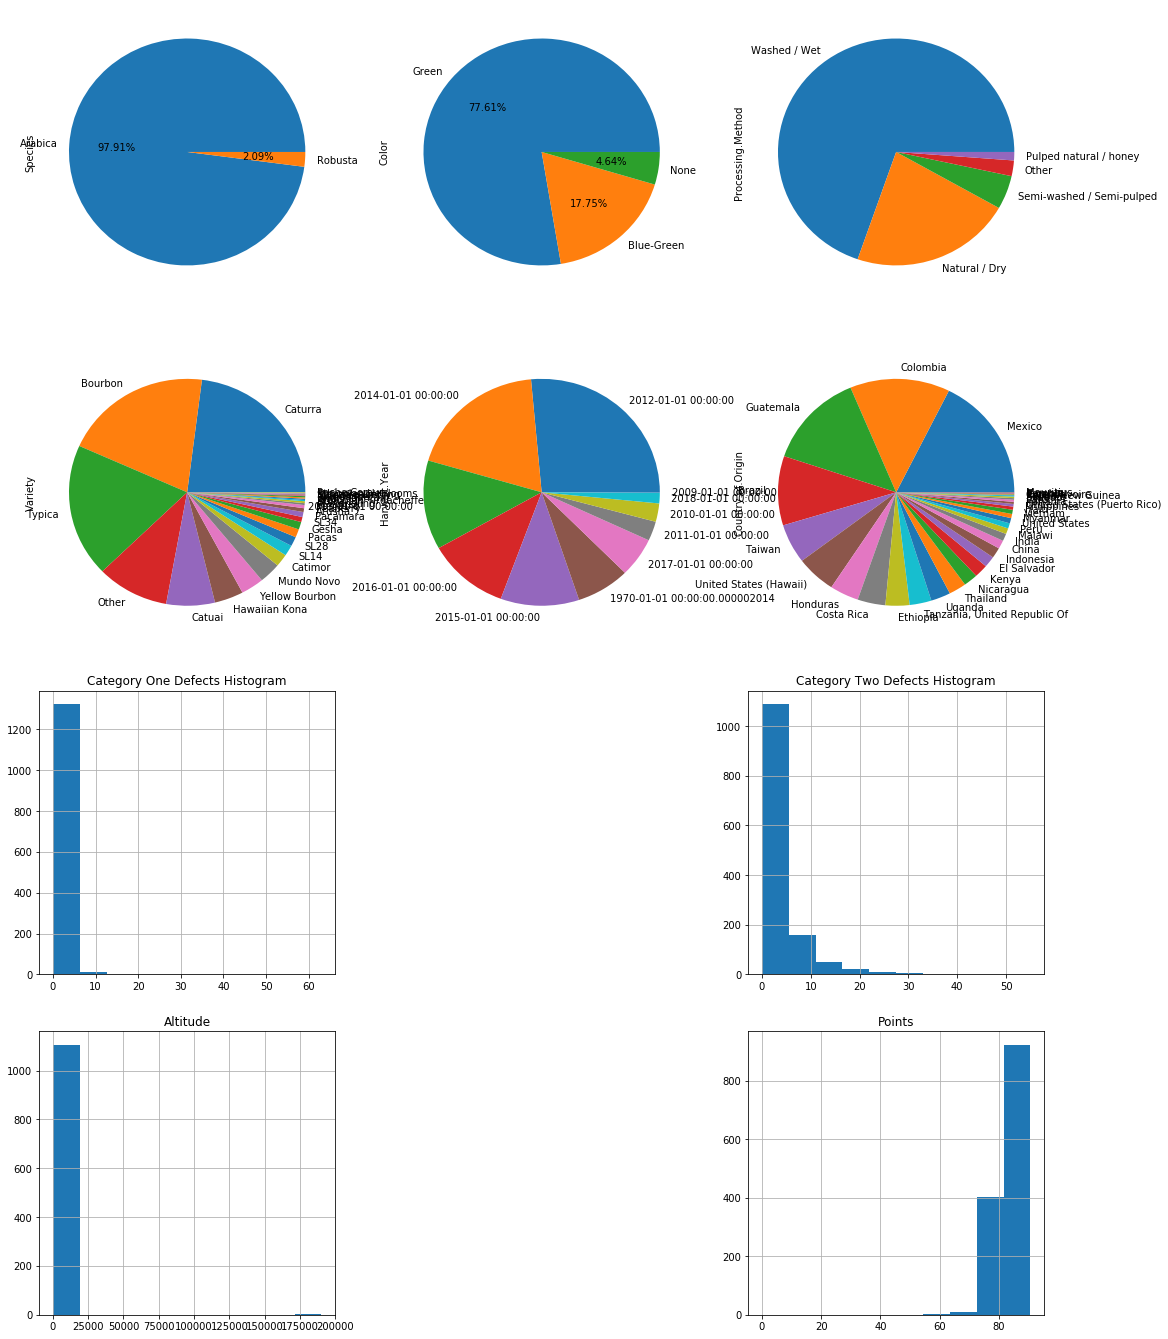

In [221]:
nRows = 4
nCols = 3

plt.figure(figsize=(6*3,8*3))

plt.subplot(nRows,nCols,1)
df_ml["Species"].value_counts().plot.pie(autopct="%.2f%%")

plt.subplot(nRows,nCols,2)
df_ml["Color"].value_counts().plot.pie(autopct="%.2f%%")

plt.subplot(nRows,nCols,3)
df_ml["Processing.Method"].value_counts().plot.pie()

plt.subplot(nRows,nCols,4)
df_ml["Variety"].value_counts().plot.pie()

plt.subplot(nRows,nCols,5)
df_ml["Harvest.Year"].value_counts().plot.pie()

plt.subplot(nRows,nCols,6)
df_ml["Country.of.Origin"].value_counts().plot.pie()

plt.subplot(nRows,nCols,7)
plt.title("Category One Defects Histogram")
df_ml["Category.One.Defects"].hist()

plt.subplot(nRows,nCols,9)
plt.title("Category Two Defects Histogram")
df_ml["Category.Two.Defects"].hist()

plt.subplot(nRows,nCols,10)
plt.title("Altitude")
df_ml["altitude_low_meters"].hist()

plt.subplot(nRows,nCols,12)
plt.title("Points")
df_ml["Total.Cup.Points"].hist()

plt.show()

In [29]:
from sklearn.preprocessing import LabelEncoder
gle = LabelEncoder()
genre_labels = gle.fit_transform(vg_df['Genre'])
genre_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
genre_mappings

NameError: name 'vg_df' is not defined